In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('.csv/cleaned_data.csv', index_col = 0)
lgb_data = df.copy()
pd.set_option('display.max_column', None)

In [3]:
lgb_data.replace(np.inf, np.nan, inplace=True)

In [4]:
lgb_data['NewExist_Encoded'] = lgb_data['NewExist'].map({1.0 : 1, 2.0: 2, np.nan: 0})
lgb_data['UrbanRural_Encoded'] = lgb_data['UrbanRural'].map({1.0 : 1, 2.0: 2, 0.0: 0}).fillna(0).astype('int64')
lgb_data['MIS_Status_Encoded'] = lgb_data['MIS_Status'].map({'CHGOFF': 0, 'PIF': 1})
lgb_data['RevLineCr_Encoded'] = lgb_data['RevLineCr'].map({'N': 1, 'Y': 2}).fillna(0).astype('int64')
lgb_data['LowDoc_Encoded'] = lgb_data['LowDoc'].map({'N': 0, 'Y': 1})
lgb_data['FranchiseCode_Encoded'] = lgb_data['FranchiseCode_Encoded'].map({'No': 0, 'Yes': 1}).astype('int64')
lgb_data['RealEstate_Backed'] = lgb_data['RealEstate_Backed'].map({'No': 0, 'Yes': 1}).astype('int64')
lgb_data['CreateJob_Encoded'] = lgb_data['CreateJob'].apply(lambda x: 1 if x > 0 else 0)
lgb_data['RetainedJob_Encoded'] = lgb_data['RetainedJob'].apply(lambda x: 1 if x > 0 else 0)
lgb_data['State'] = lgb_data['State'].astype('category')
lgb_data['StateRisk'] = lgb_data['StateRisk'].astype('category')
lgb_data['Region'] = lgb_data['Region'].astype('category')

In [5]:
lgb_data.loc[:, 'EmployeeLoanRatio'] = lgb_data.apply(
    lambda row: round(row['GrAppv']) if pd.isna(row['EmployeeLoanRatio']) else round(row['EmployeeLoanRatio']),
    axis=1
).astype('int64')

In [6]:
lgb_data.drop(labels=['LoanNr_ChkDgt', 'Name', 'City', 'Bank', 'BankState', 'TermDays', 'ApprovalDate', 'ApprovalFY', 'Zip', 'DisbursementDate', 
                      'DisbursementGross','NewExist', 'RetainedJob', 'LowDoc' ,'UrbanRural', 'RevLineCr', 'ChgOffDate',
                      'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'SBA_Appv', 'Industry',
                       'ApprovalDateYear', 'ChgOffDateYear', 'ApprovalDateMonth', 'DisbursementDateYear',
                       'LoanDateEnd'], axis=1, inplace=True )

In [7]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS',]
categorical_features = ['FranchiseCode_Encoded', 'RealEstate_Backed','NAICS_class_code',
                        'Recession', 'NewExist_Encoded', 'UrbanRural_Encoded', 'RevLineCr_Encoded',
                        'LowDoc_Encoded', 'CreateJob_Encoded', 'Region_Eastern', 
                        'Region_Northern', 'Region_Southern', 'Region_Western'
                        ]

scaler = StandardScaler()
scaled_numerics = scaler.fit_transform(lgb_data[numerical_features])

lgb_data[numerical_features] = scaled_numerics

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = lgb_data.drop(columns=['MIS_Status_Encoded'])
y = lgb_data['MIS_Status_Encoded']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
import lightgbm as lgb

# Define model
lgb_model = lgb.LGBMClassifier(boosting_type= 'dart',
                            n_jobs = 7,
                            bagging_fraction=0.8, 
                            bagging_freq=1,
                            feature_fraction=0.8, 
                            importance_type='gain',
                            min_child_weight=0.1, 
                            min_split_gain=0.1,
                            objective='binary',
                            subsample=1.0,
                            learning_rate=0.2777,
                            n_estimators= 800,
                            )

lgb_model.fit(X_train, y_train)

lgb_train_score = lgb_model.score(X_train, y_train)

print("Training Score:", round(lgb_train_score, 2))

# Store model parameters in a DataFrame
best_lgb_params = lgb_model.get_params()  # Get model's hyperparameters
best_lgb_params_df = pd.DataFrame([best_lgb_params])

# Save to CSV
best_lgb_params_df.to_csv("best_lgb_params_2.csv", index=False)

print("Best parameters saved to CSV successfully!")

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 591687, number of negative: 126255
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

In [10]:
from sklearn.metrics import classification_report

# Make predictions
lgb_y_pred = lgb_model.predict(X_test)

# Calculate the accuracy
lgb_classification_report = classification_report(y_test, lgb_y_pred)

print(lgb_classification_report)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
              precision    recall  f1-score   support

           0       0.86      0.82      0.84     31564
           1       0.96      0.97      0.97    147922

    accuracy                           0.94    179486
   macro avg       0.91      0.90      0.90    179486
weighted avg       0.94      0.94      0.94    179486



In [11]:
from sklearn.model_selection import cross_val_score

# Evaluate model using cross-validation
lgb_roc_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'ROC-AUC: {round(lgb_roc_scores.mean(),2)}')

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 101004
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

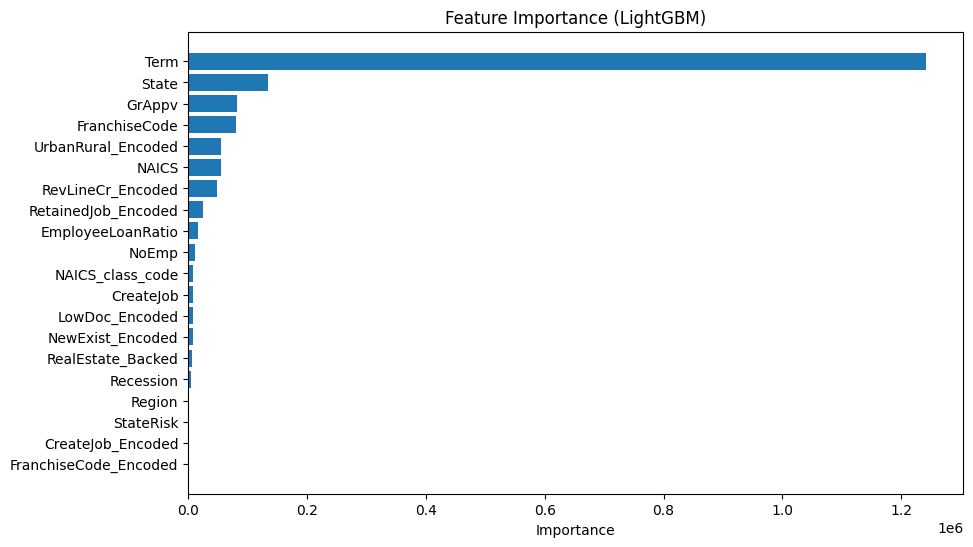

In [12]:
# Vizualize Feature Importance
feature_importance = pd.DataFrame({'Feature': lgb_model.feature_name_, 'Importance': lgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.show()


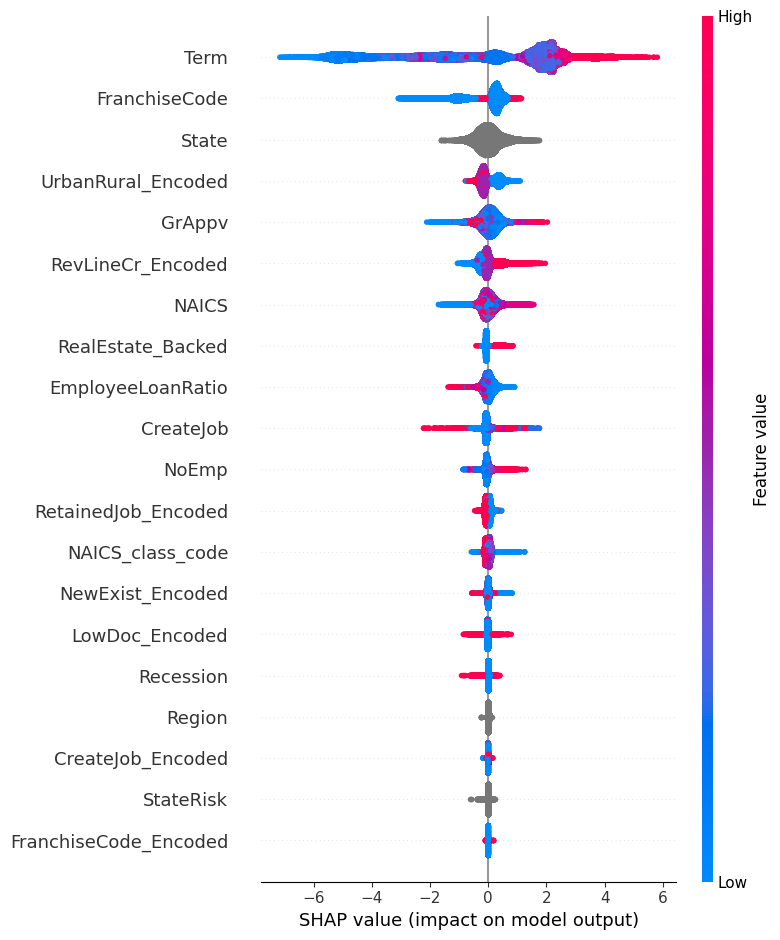

ValueError: Could not find feature named: FeatureName

In [ ]:
import shap


explainer = shap.TreeExplainer(lgb_model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test)

# Summary Plot (Global feature importance)
shap.summary_plot(shap_values, X_test)

# Force Plot (Explains individual predictions)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_test.iloc[0, :])
